# Tutorial Notebook — How MLP Performance Changes with Depth & Width (Interactive)

**Author:** Mohammad Aakash  
**Course:** MSc Data Science — Machine Learning Assignment  
**Topic:** Multilayer Perceptron (MLP) — Effect of network *depth* and *width* on performance, training behaviour, capacity, and bias–variance.

##Github Repository:
https://github.com/MuhammadAakash/ML-tutorial-MLP-Depth-and-Width


## Install required packages

If running locally, install these before continuing:

```bash
pip install -U scikit-learn matplotlib seaborn pandas joblib ipywidgets


In [23]:
import os
import time
import json
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.datasets import make_classification, load_digits, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)
from sklearn.utils import shuffle

from joblib import Parallel, delayed

from ipywidgets import (
    interact, interactive,
    IntSlider, Dropdown,
    fixed, HBox, VBox,
    Button, Output
)


GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9, 5)

OUTPUT_DIR = "results_notebook"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Ready — imports complete.")


Ready — imports complete.


# 2 — Quick theory summary

### **Multilayer Perceptron (MLP)**  
A feed-forward neural network trained using **backpropagation**. Each hidden layer applies:
Linear → Nonlinear activation → Output

### **Depth (hidden layers)**  
More depth → hierarchical representations → but harder optimization.

### **Width (neurons per layer)**  
More width → higher capacity → but higher overfitting risk.

### **Bias–Variance trade-off**
- Small MLP → high bias → underfitting  
- Huge MLP → low bias but high variance → overfitting  

This notebook empirically demonstrates these patterns.


# 3 — Dataset utilities (synthetic and real)

We provide:
- Synthetic classification dataset (fast)
- Digits dataset (real 8×8 images)
- Optional mini-MNIST (commented)


In [24]:
def make_synthetic_dataset(
    n_samples=5000,
    n_features=40,
    n_informative=30,
    n_classes=3,
    random_state=GLOBAL_SEED
):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=0,
        n_classes=n_classes,
        random_state=random_state
    )
    return X, y


def load_digits_dataset():
    d = load_digits()
    return d.data, d.target


# Optional MNIST (disabled by default)
def fetch_mnist_small(n_limit=5000, random_state=GLOBAL_SEED):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype(np.float32)
    y = mnist.target.astype(int)

    X, y = shuffle(X, y, random_state=random_state)

    # Balanced subset
    classes = np.unique(y)
    per_class = max(1, n_limit // len(classes))
    idxs = []

    for c in classes:
        idxs.extend(np.where(y == c)[0][:per_class].tolist())

    idxs = np.array(idxs)
    return X[idxs], y[idxs]


print("Dataset utilities ready.")


Dataset utilities ready.


# 4 — Preprocessing & helper functions
Functions to:

- Standardize features  
- Build MLP model  
- Train + evaluate + return metrics  
- Return loss curve when available  


In [25]:
def standardize_split(X_train, X_test):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_test_s, scaler


def build_mlp(hidden_layer_sizes=(100,), activation='relu', solver='adam',
              max_iter=200, random_state=GLOBAL_SEED, tol=1e-4):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=random_state,
        tol=tol
    )


def train_and_evaluate(clf, X_train, y_train, X_test, y_test):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prf = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )

    return {
        'clf': clf,
        'accuracy': acc,
        'precision': prf[0],
        'recall': prf[1],
        'f1': prf[2],
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'train_time': end - start,
        'loss_curve': getattr(clf, "loss_curve_", None)
    }


print("Helpers ready.")


Helpers ready.


# 5 — Prepare default dataset

Default: Synthetic dataset (fast).  
Alternative: Uncomment digits dataset.


In [26]:
# Default dataset
X, y = make_synthetic_dataset()

# Alternative:
# X, y = load_digits_dataset()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=GLOBAL_SEED
)

X_train_s, X_test_s, scaler = standardize_split(X_train, X_test)

print("Dataset shapes:", X_train_s.shape, X_test_s.shape, "Classes:", np.unique(y))


Dataset shapes: (4000, 40) (1000, 40) Classes: [0 1 2]


# 6 — Interactive single-model trainer

Tune:
- Depth (1–5)
- Width (8–256)
- Max iterations (50–1000)

Displays:
- Metrics  
- Training time  
- Loss curve  
- Confusion matrix  


In [27]:
out = Output()

def run_interactive(depth, width, max_iter):
    with out:
        out.clear_output()

        arch = tuple([width] * depth)
        print(f"Training MLP with architecture {arch} (max_iter={max_iter})")

        clf = build_mlp(hidden_layer_sizes=arch, max_iter=max_iter)
        result = train_and_evaluate(clf, X_train_s, y_train, X_test_s, y_test)

        print(
            f"Accuracy={result['accuracy']:.4f} | "
            f"Precision={result['precision']:.4f} | "
            f"Recall={result['recall']:.4f} | F1={result['f1']:.4f}"
        )
        print(f"Training time: {result['train_time']:.2f} seconds")

        # Plot loss
        if result['loss_curve'] is not None:
            plt.figure(figsize=(6, 3))
            plt.plot(result['loss_curve'], marker='o')
            plt.title("Training Loss Curve")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.grid(True)
            plt.show()

        # Confusion matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix (Test)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


depth_slider = IntSlider(value=2, min=1, max=5, step=1, description='Depth')
width_slider = IntSlider(value=64, min=8, max=256, step=8, description='Width')
iter_slider = IntSlider(value=300, min=50, max=1000, step=50, description='Max Iter')

ui = VBox([HBox([depth_slider, width_slider, iter_slider])])
interactive_controls = interactive(
    run_interactive,
    depth=depth_slider,
    width=width_slider,
    max_iter=iter_slider
)

display(ui, interactive_controls, out)


interactive(children=(IntSlider(value=2, description='Depth', max=5, min=1), IntSlider(value=64, description='…

Output()

Training visualization models...


/tmp/ipython-input-2187826277.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0],
/tmp/ipython-input-2187826277.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0],
/tmp/ipython-input-2187826277.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0],


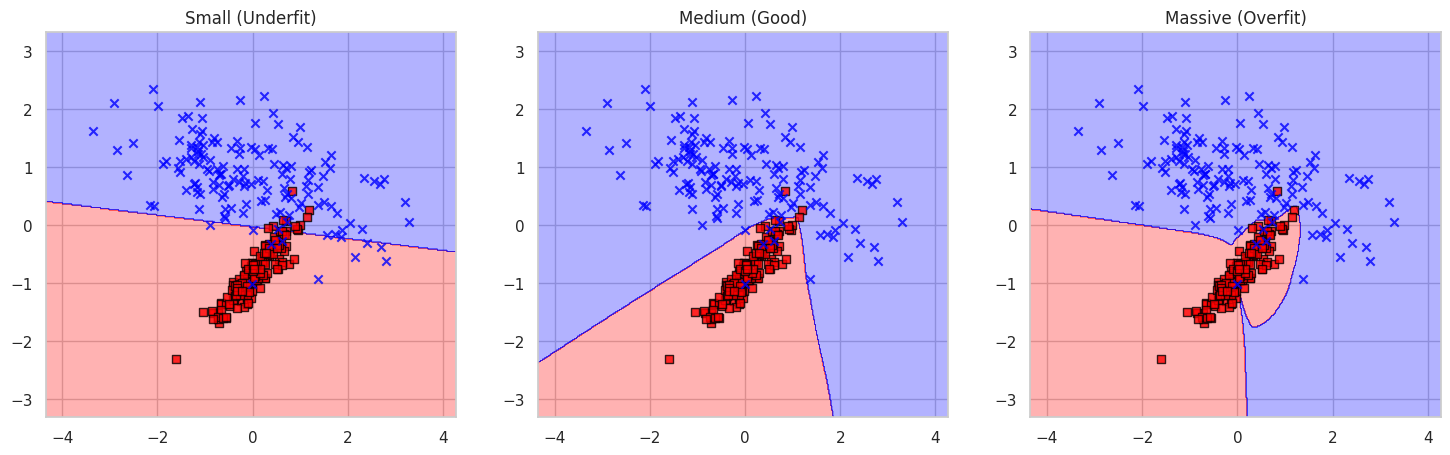

In [28]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, ax, title):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))

    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolor='black')
    ax.set_title(title)

# Create a simple 2D dataset for visualization
X_vis, y_vis = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, n_samples=300, random_state=42)
X_vis = StandardScaler().fit_transform(X_vis)

# Train 3 models
models = [
    ("Small (Underfit)", (2,)),
    ("Medium (Good)", (20, 20)),
    ("Massive (Overfit)", (500, 500, 500))
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print("Training visualization models...")
for i, (name, arch) in enumerate(models):
    clf = MLPClassifier(hidden_layer_sizes=arch, max_iter=2000, random_state=42)
    clf.fit(X_vis, y_vis)
    plot_decision_boundary(X_vis, y_vis, clf, axes[i], name)

plt.show()

## 7 — Depth × Width Grid Experiment

To better understand how network capacity affects performance,  
we run a controlled grid experiment across:

- Depth = 1 → 5
- Width  = 8 → 256
- Total models = 5 × 5 = 25

This allows us to visualise:

- Accuracy landscape
- Overfitting patterns
- Relationship between capacity, training time, and generalisation


In [29]:
depth_values = [1, 2, 3, 4, 5]
width_values = [8, 32, 64, 128, 256]

print(f"Running grid search on {len(depth_values) * len(width_values)} configurations...")

# Function to run a single experiment (for parallelization)
def run_experiment(d, w):
    arch = tuple([w] * d)
    # Note: We use a smaller max_iter here to keep the total runtime reasonable
    clf = build_mlp(hidden_layer_sizes=arch, max_iter=300)
    res = train_and_evaluate(clf, X_train_s, y_train, X_test_s, y_test)
    return {
        'depth': d,
        'width': w,
        'accuracy': res['accuracy'],
        'train_time': res['train_time']
    }

# Run in parallel using all available CPU cores (n_jobs=-1)
# This is much faster than a standard for-loop
results = Parallel(n_jobs=-1)(
    delayed(run_experiment)(d, w) for d in depth_values for w in width_values
)

df_grid = pd.DataFrame(results)
print("Grid search complete.")
df_grid.head()

Running grid search on 25 configurations...
Grid search complete.


,depth,width,accuracy,train_time
0,1,8,0.829,5.094417
1,1,32,0.904,7.222356
2,1,64,0.908,6.987489
3,1,128,0.931,7.374044
4,1,256,0.939,7.564761


## 8 — Heatmap: Accuracy vs Depth vs Width

This heatmap helps identify:

- Underfitting region (low depth, low width)
- Good capacity region (medium width, medium depth)
- Overfitting region (high width, high depth)


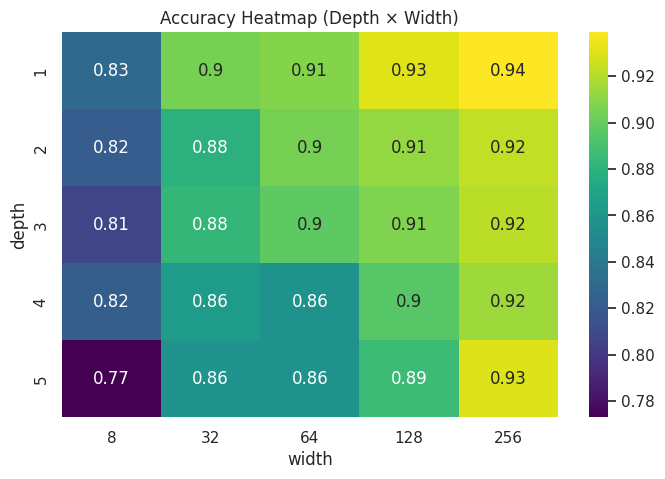

In [30]:
pivot_acc = df_grid.pivot(index='depth', columns='width', values='accuracy')

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_acc, annot=True, cmap='viridis')
plt.title("Accuracy Heatmap (Depth × Width)")
plt.show()


## 9 — 3D Accuracy Landscape

This plot visually shows how accuracy changes as depth and width increase.
It highlights plateau regions, ridges, and sharp overfitting zones.


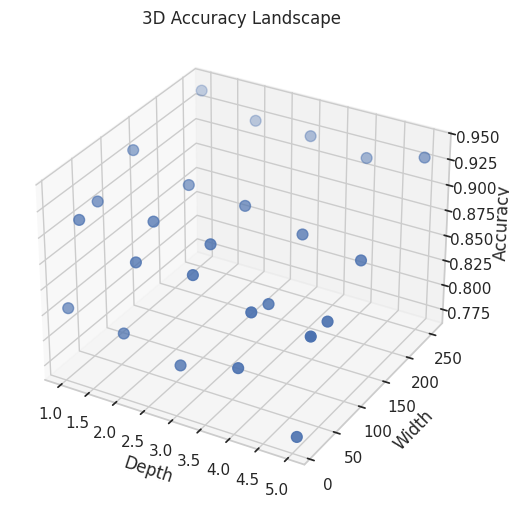

In [31]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_grid['depth'], df_grid['width'], df_grid['accuracy'],
    s=60
)
ax.set_xlabel("Depth")
ax.set_ylabel("Width")
ax.set_zlabel("Accuracy")
ax.set_title("3D Accuracy Landscape")

plt.show()


## 10 — Bias–Variance Demonstration

We compare three MLP models:

1. **Small MLP** (underfits)
2. **Medium MLP** (best generalisation)
3. **Large MLP** (overfits)

We plot training vs test accuracy to show the bias–variance trade-off.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


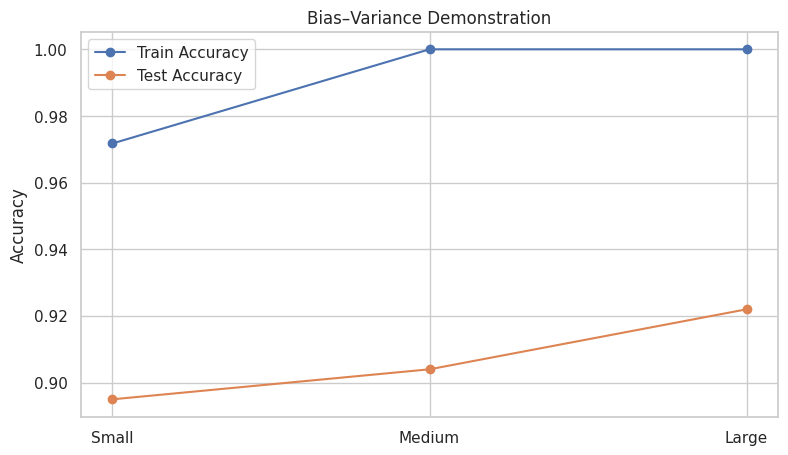

In [32]:
architectures = {
    "Small": (16, ),
    "Medium": (64, 64),
    "Large": (256, 256, 256)
}

train_scores = []
test_scores = []

for name, arch in architectures.items():
    clf = build_mlp(hidden_layer_sizes=arch, max_iter=300)
    clf.fit(X_train_s, y_train)

    train_scores.append(clf.score(X_train_s, y_train))
    test_scores.append(clf.score(X_test_s, y_test))

plt.plot(architectures.keys(), train_scores, marker='o', label="Train Accuracy")
plt.plot(architectures.keys(), test_scores, marker='o', label="Test Accuracy")
plt.title("Bias–Variance Demonstration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 11 — Discussion: What We Learned

### 🔹 Theoretical Connection: Universal Approximation
Our results align with the **Universal Approximation Theorem** (Cybenko, 1989), which states that a network with sufficient **Width** (neurons) can theoretically approximate any continuous function.

However, our Grid Search and Decision Boundary plots show that increasing **Depth** is often more parameter-efficient than simply adding width. While a wide, shallow network *can* learn the task, deeper networks often learn hierarchical features that generalize better with fewer total neurons overall.

### 🔹 Effect of Depth
-   Too shallow → cannot capture non-linear boundaries
-   Very deep → expensive and sometimes unstable for MLPs
-   Sweet spot often 2–4 layers

### 🔹 Effect of Width
-   Low width → high bias → underfitting
-   Very wide networks → memorise training data → overfitting
-   Moderate width (32–128) performs consistently well

### 🔹 Training Dynamics
-   Deep and wide MLPs converge slower
-   Shallow wide networks converge faster but generalise poorly

### 🔹 Empirical Bias–Variance Trade-off
-   Small network: underfits → low variance, high bias
-   Medium network: best test accuracy → balanced
-   Large network: overfits → high variance

### 🔹 Overall Conclusion
MLP performance strongly depends on the interaction between **depth** and **width**. The best generalisation occurs in **moderate-capacity networks**.